In [1]:
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import umap

import scvi
from scvi.model import CondSCVI, DestVI

import torch

%matplotlib inline

Global seed set to 0


In [2]:
sc.set_figure_params(scanpy=True)

In [3]:
!wget --quiet https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/ST-LN-compressed.h5ad?raw=true -O ST-LN-compressed.h5ad
!wget --quiet https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/scRNA-LN-compressed.h5ad?raw=true -O scRNA-LN-compressed.h5ad

In [4]:
sc_adata = sc.read_h5ad("scRNA-LN-compressed.h5ad")

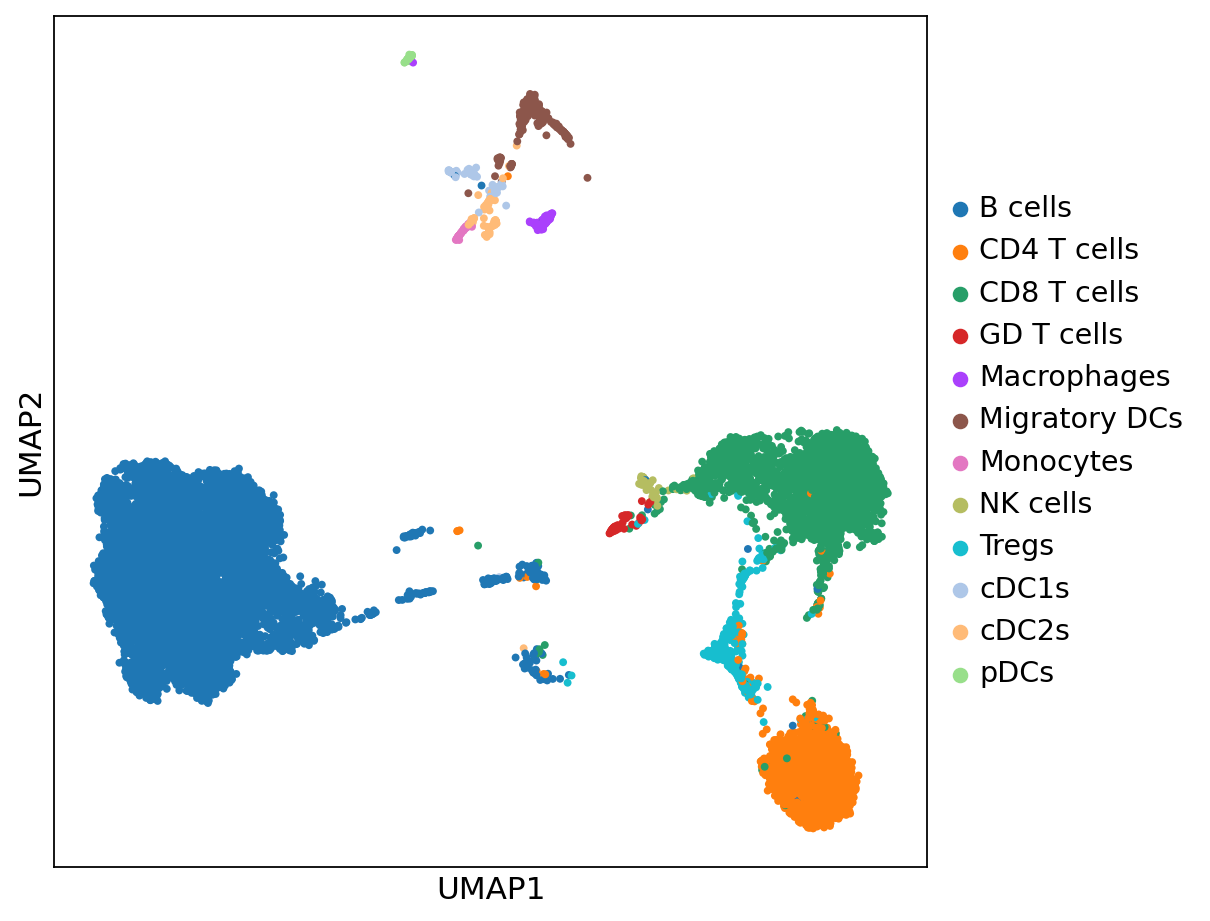

In [5]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7,7),
)
sc.pl.umap(sc_adata, color="broad_cell_types", ax=ax, show=False, size=50,title="")
plt.show()

In [6]:
sc.pp.filter_genes(sc_adata, min_counts=10)
sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)

In [7]:
st_adata = sc.read_h5ad("ST-LN-compressed.h5ad")

In [8]:
st_adata.layers["counts"] = st_adata.X.copy()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)

In [9]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

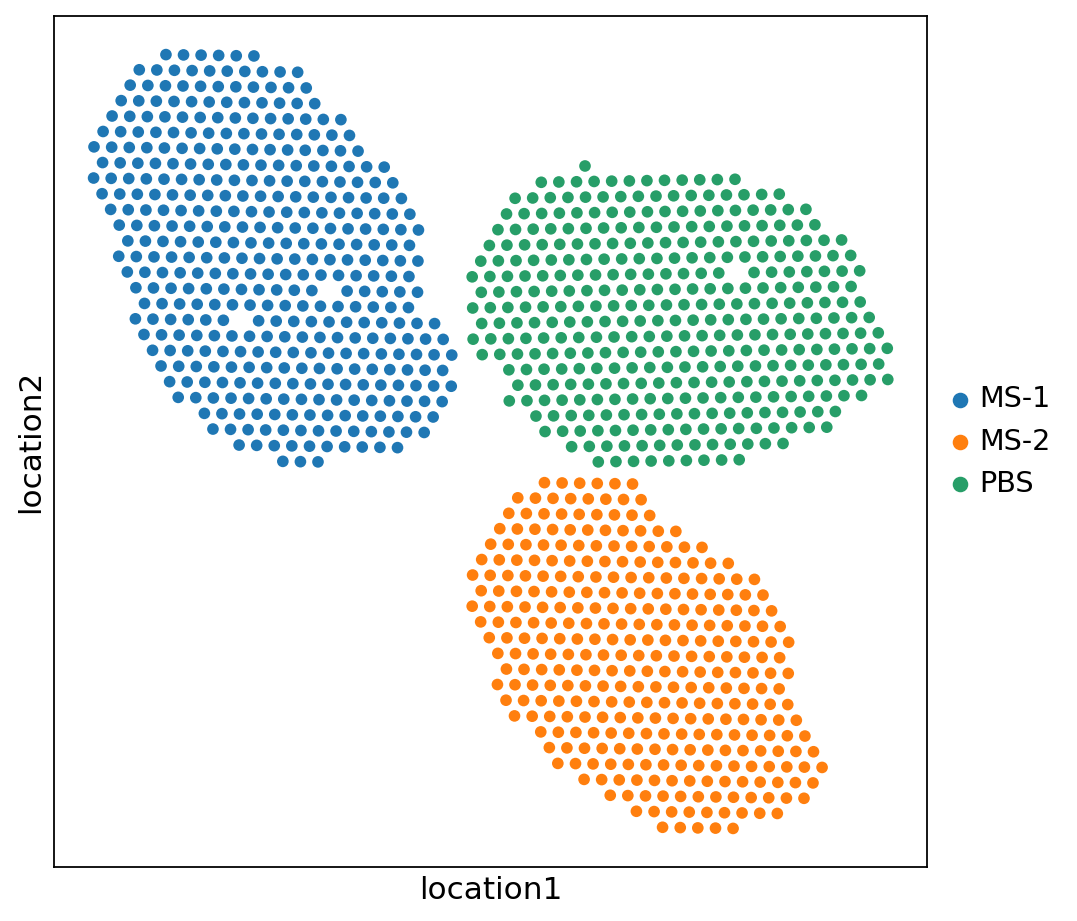

In [10]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(7,7),
)
sc.pl.embedding(st_adata, basis="location", color="lymph_node", ax=ax, show=False, title="")
plt.show()

In [11]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["broad_cell_types"]                                     
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 14989 cells, 1888 vars, 1 batches,
         12 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


In [12]:
sc_model = CondSCVI(sc_adata, weight_obs=True)
sc_model.train(max_epochs=250)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|████████████████████████████████████████████████████████████████████| 250/250 [03:55<00:00,  1.06it/s, loss=6.32e+03, v_num=1]


In [13]:
DestVI.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 1092 cells, 1888 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [14]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.train(max_epochs=2500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2500/2500: 100%|████████████████████████████████████████████████████████████████| 2500/2500 [03:55<00:00, 10.60it/s, loss=1.91e+06, v_num=1]


In [15]:
st_adata.obsm["proportions"] = st_model.get_proportions()

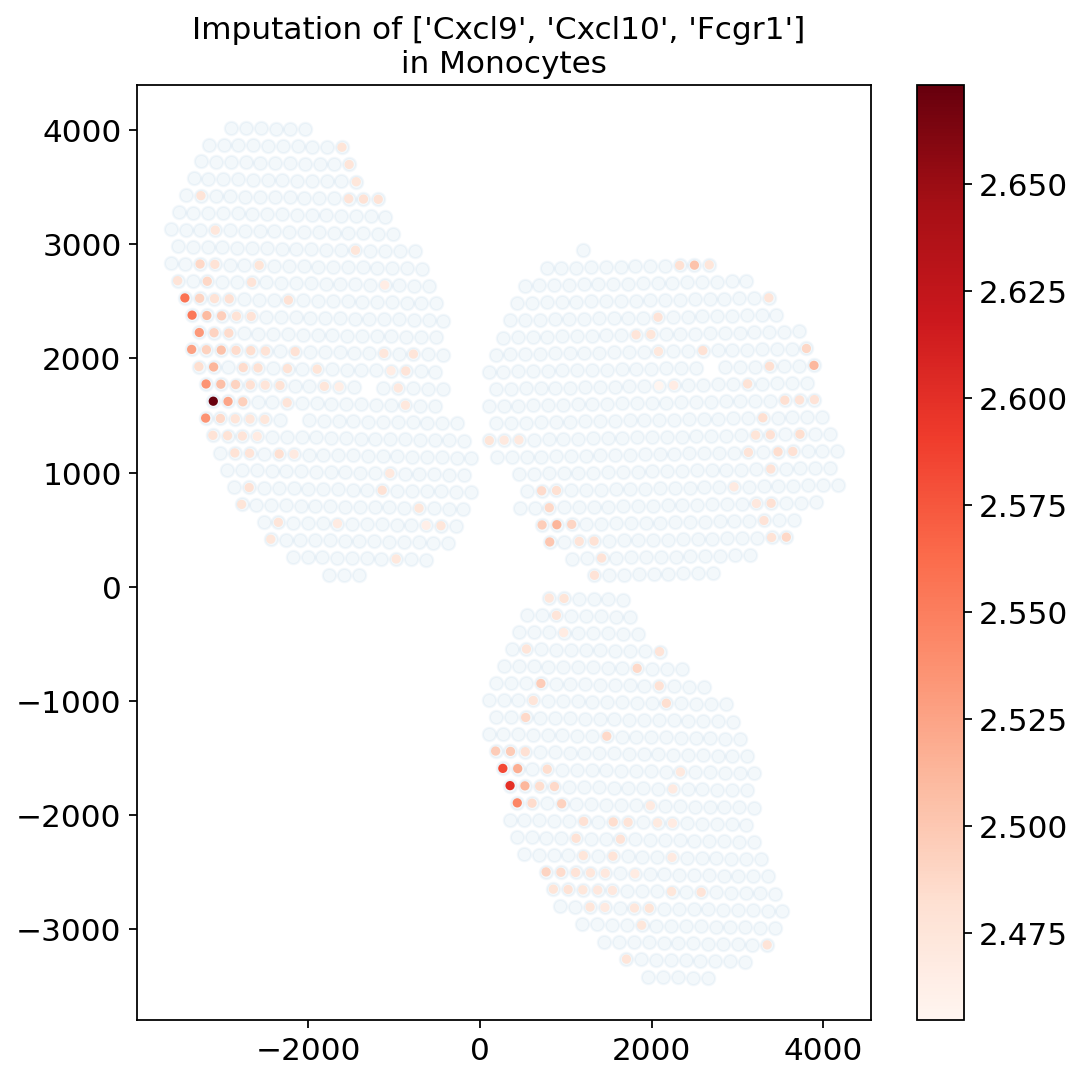

In [16]:
plt.rcParams['axes.grid'] = False
plt.figure(figsize=(7, 7))

ct_name = "Monocytes"
gene_name = ["Cxcl9", "Cxcl10", "Fcgr1"]


# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.03)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(st_adata.obsm["location"][indices][:, 0], st_adata.obsm["location"][indices][:, 1],
            c=specific_expression, s=10, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name} \nin {ct_name}")
plt.tight_layout()
plt.show()

In [17]:
cell_expression = []
node_types = []
gammas = []
proportions = []
spatial = []
for i, ct in enumerate(st_model.cell_type_mapping):
    prop = st_model.get_proportions()
    indices = np.where(prop[ct] > 0.03)[0]
    proportions.append(prop.iloc[indices,:])
    scale = np.array(st_model.get_scale_for_ct(ct, indices=indices))
    cell_expression.append(scale)
    nt = np.zeros((scale.shape[0], len(st_model.cell_type_mapping)))
    nt[:, i] = 1
    node_types.append(nt)
    g = np.array(st_model.get_gamma(indices=indices)[ct])
    gammas.append(g)
    spatial.append(st_adata.obsm['spatial'][indices,:])

proportions = pd.DataFrame(np.concatenate(proportions), columns=st_model.cell_type_mapping)
cell_expression = pd.DataFrame(np.concatenate(cell_expression), columns=st_adata.var_names)
cell_expression = np.log(1+ 1e4 * cell_expression)
node_types = pd.DataFrame(np.concatenate(node_types), columns=st_model.cell_type_mapping)
gammas = pd.DataFrame(np.concatenate(gammas))
spatial = pd.DataFrame(np.concatenate(spatial))

In [18]:
ad = AnnData(gammas)
ad.obsm['proportions'] = np.array(proportions)
ad.obsm['node_types'] = np.array(node_types)
ad.obsm['cell_expression'] = np.array(cell_expression)
ad.obsm['spatial'] = np.array(spatial)

ad.uns["node_type_names"] = {x: x for x in st_model.cell_type_mapping}

path = '.'
fn = '/destvi_gamma/destVI_lymphnode.h5ad'
ad.write(path + fn)

/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
ad = AnnData(cell_expression)
ad.obsm['proportions'] = np.array(proportions)
ad.obsm['node_types'] = np.array(node_types)
ad.obsm['gamma'] = np.array(gammas)
ad.obsm['spatial'] = np.array(spatial)

ad.uns["node_type_names"] = {x: x for x in st_model.cell_type_mapping}
path = '.'
fn = '/destvi/destVI_lymphnode.h5ad'
ad.write(path + fn)